In [1]:
import pandas as pd

df = pd.read_csv("../../complaints-2020-01-22_08_24.csv", encoding="utf-8")

df_selected = df.loc[:, ('Product', 'Consumer complaint narrative', 'Issue', 'Sub-issue')]

---

__Functions to clean the Consumer complaint narrative__

In [2]:
import re
import string

def clean_url(complaint):
    # to do: more regex url garbage matching
    complaint = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', complaint)
    complaint = re.sub('https? ?: ?// ?(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', complaint)
    return complaint

# Remove punctuation from complaint
def clean_punctuation(complaint):
    complaint = re.sub('[%s]' % re.escape(string.punctuation), '', complaint)
    return complaint

# Remove non-sensical characters from complaint
def clean_nonsense(complaint):
    complaint = re.sub('[''""...]', '', complaint)
    complaint = re.sub('\n', '', complaint)
    return complaint

# Remove censored words from complaint
def clean_censored(complaint):
    complaint = re.sub('[XXXX]', '', complaint)
    return complaint

# Turn everything into lowercase
def clean_lowercase(complaint):
    complaint = complaint.lower()
    return complaint

# Remove numbers from complaint
def clean_numbers(complaint):
    complaint = re.sub('\w*\d\w', '', complaint)
    return complaint

__Application of narrative cleaning__

In [3]:
df_selected["Consumer complaint narrative"] = df_selected["Consumer complaint narrative"].apply(clean_url)
df_selected["Consumer complaint narrative"] = df_selected["Consumer complaint narrative"].apply(clean_punctuation)
df_selected["Consumer complaint narrative"] = df_selected["Consumer complaint narrative"].apply(clean_nonsense)
df_selected["Consumer complaint narrative"] = df_selected["Consumer complaint narrative"].apply(clean_censored)
df_selected["Consumer complaint narrative"] = df_selected["Consumer complaint narrative"].apply(clean_lowercase)
df_selected["Consumer complaint narrative"] = df_selected["Consumer complaint narrative"].apply(clean_numbers)

**Apply CountVectorizer**

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

# vect (bag of words)
count_vect = CountVectorizer(
    stop_words="english",
    #ngram_range=(1,2), # bigrammen
    min_df=2, # only keep words that appear twice
    max_df=0.5 # appears max in 50% of documents
)

X_train_counts = count_vect.fit_transform(df_selected["Consumer complaint narrative"])

**Apply TF-IDF**

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer

# Normalise with tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print('Shape', X_train_tfidf.shape)
print(X_train_tfidf)

Shape (485701, 77541)
  (0, 77176)	0.057603117293145815
  (0, 76652)	0.16256155704199224
  (0, 75309)	0.0704998089772363
  (0, 75075)	0.06367724939199933
  (0, 74968)	0.09219266901371895
  (0, 73727)	0.12517299128438755
  (0, 71967)	0.17949182587880833
  (0, 69841)	0.11897824400517687
  (0, 69713)	0.05790316684384142
  (0, 69322)	0.11526692039409442
  (0, 69116)	0.0919644454692771
  (0, 67077)	0.0945540081983084
  (0, 66813)	0.13729499089431052
  (0, 65093)	0.10163692275565259
  (0, 63443)	0.12076334352602229
  (0, 62631)	0.062129528417944724
  (0, 62615)	0.12209465027976771
  (0, 62146)	0.11073198116064686
  (0, 61559)	0.07623732630893473
  (0, 59674)	0.09011779388563108
  (0, 59664)	0.09770742191644613
  (0, 58514)	0.05250540217562024
  (0, 58403)	0.04014663511243601
  (0, 57662)	0.14368581222288473
  (0, 56871)	0.14107643748845286
  :	:
  (485700, 72656)	0.20663930774149367
  (485700, 71225)	0.26283911340165067
  (485700, 70092)	0.0918765457662843
  (485700, 61605)	0.194740851743595

**Dimensionality Reduction**

In [6]:
from sklearn.decomposition import TruncatedSVD

tSVD = TruncatedSVD(n_components=5)

principal_components = tSVD.fit_transform(X_train_tfidf)
print(principal_components.shape)

(485701, 5)


__One hot encoding of extra columns__

In [7]:
principal_components_df = pd.DataFrame(principal_components)

df_selected['Issue'] = pd.Categorical(df_selected['Issue'])
df_dummies1 = pd.get_dummies(df_selected['Issue'])

df_selected['Sub-issue'] = pd.Categorical(df_selected['Sub-issue'])
df_dummies2 = pd.get_dummies(df_selected['Sub-issue'], prefix = 'Sub-issue')

df_concat = pd.concat([principal_components_df, df_dummies1, df_dummies2], axis = 1)
print(df_concat)

               0         1         2         3         4  \
0       0.187932  0.021641  0.008080 -0.000389 -0.029593   
1       0.123744  0.042856 -0.123232  0.076037 -0.013675   
2       0.177520  0.029204  0.166449 -0.004950 -0.022036   
3       0.196346  0.083372  0.261280  0.083967  0.075352   
4       0.277748  0.005826  0.132761  0.054376 -0.109208   
5       0.194632  0.027129  0.181618  0.018732 -0.040519   
6       0.155708  0.147269 -0.037774 -0.067199 -0.028161   
7       0.187517  0.221389 -0.054454 -0.071284  0.024971   
8       0.070227  0.066866 -0.025930 -0.018168 -0.024699   
9       0.194028 -0.193862  0.005152 -0.078067  0.034165   
10      0.186641  0.129152  0.131532  0.037897  0.062978   
11      0.187084 -0.099685  0.004234 -0.034368  0.006726   
12      0.206061 -0.112223 -0.075448 -0.003240  0.008917   
13      0.245872  0.154742  0.048507 -0.025743  0.021896   
14      0.200794  0.019973 -0.104407  0.045823  0.172406   
15      0.250800  0.159417 -0.170432  0.

**Split into train & test**

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df_concat, df_selected['Product'])
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(364275, 383)
(121426, 383)
(364275,)
(121426,)


**Run algorithm**

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report # do more stats

clf = RandomForestClassifier()
clf.fit(X_train, Y_train)

test_predictions = clf.predict(X_test)

**Report**

In [10]:
print(classification_report(test_predictions, Y_test))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       1.00      1.00      1.00      3866
                                                 Checking or savings account       0.99      1.00      1.00      4652
                                                               Consumer Loan       0.98      1.00      0.99      2333
                                                                 Credit card       1.00      0.99      0.99      4814
                                                 Credit card or prepaid card       0.96      0.99      0.97      7558
                                                            Credit reporting       1.00      1.00      1.00      7924
Credit reporting, credit repair services, or other personal consumer reports       1.00      0.98      0.99     36253
                                                       

#### Confusion Matrix

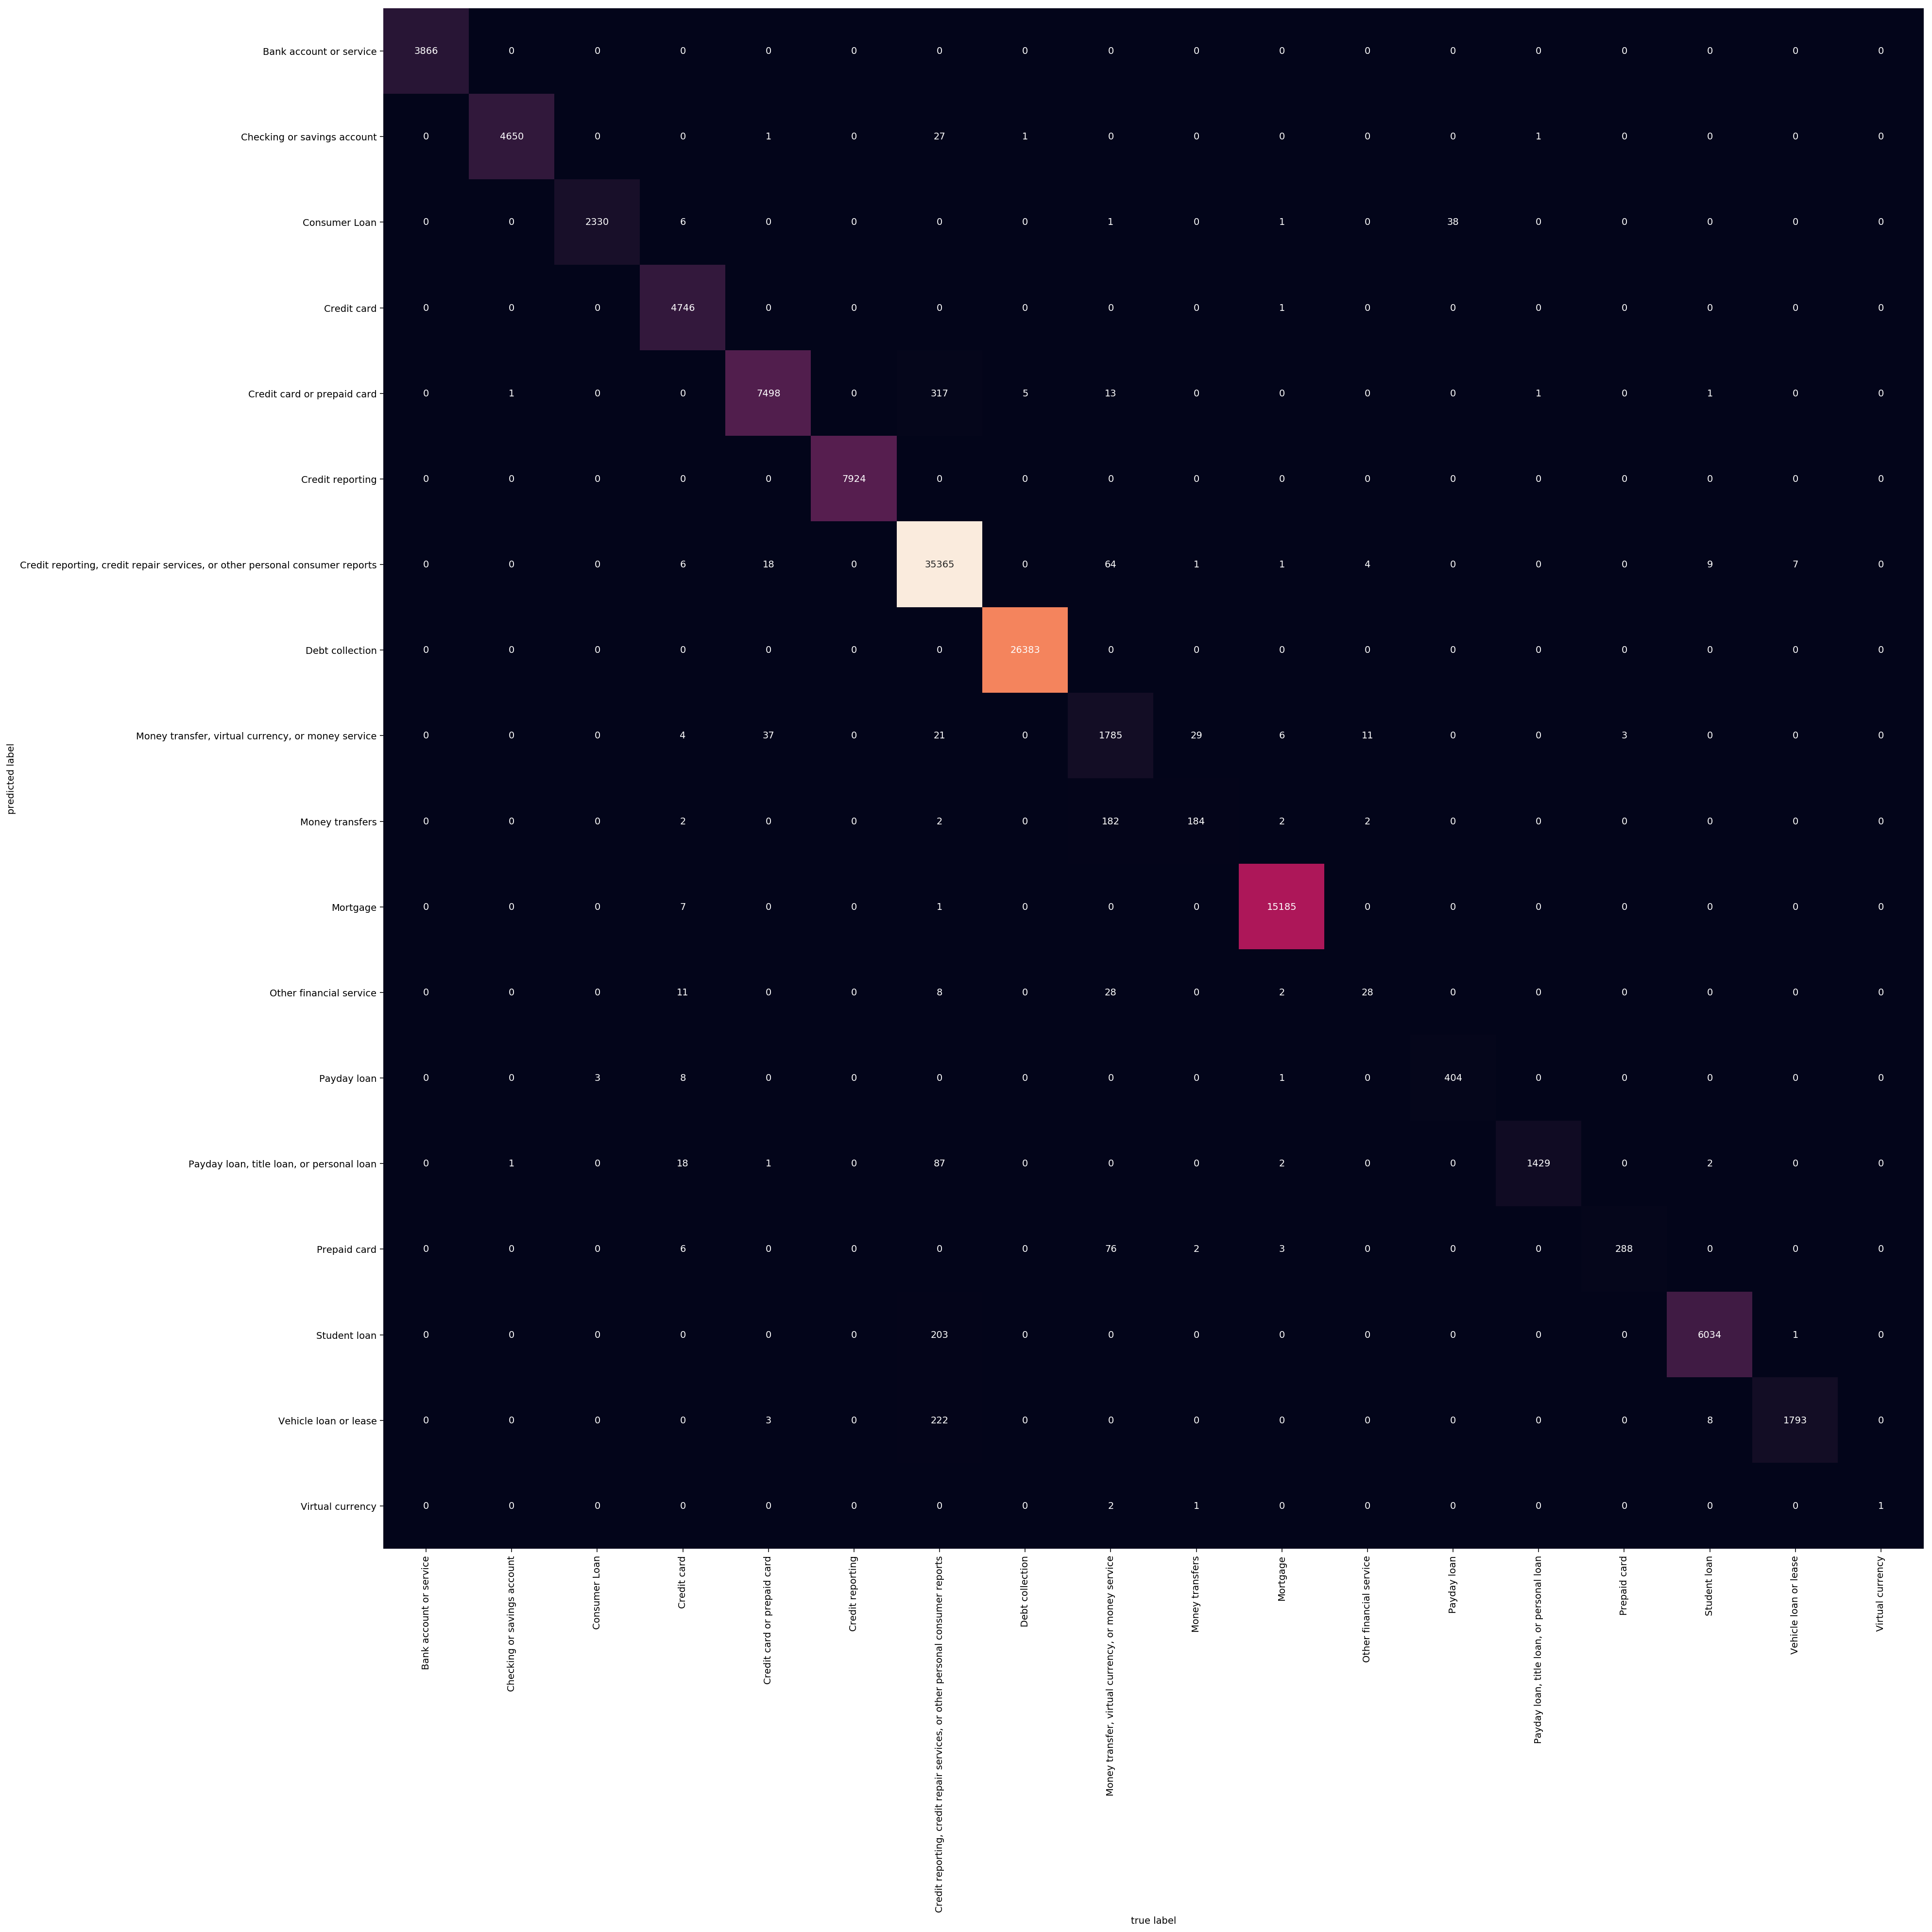

In [13]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

from sklearn.metrics import confusion_matrix

labels = df_selected["Product"].unique()
labels.sort()
conf_matrix = confusion_matrix(test_predictions, Y_test)
sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=labels,
           yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label');


rcParams['figure.figsize'] = 40, 40
rcParams['figure.dpi'] = 140
#plot_confusion_matrix(clf, principal_components_test, Y_test, xticks_rotation='vertical')